In [1]:
import pickle
import datetime
import numpy as np
from pathlib import Path
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from torch import optim
from torch.optim.lr_scheduler import ReduceLROnPlateau
from torch.utils.data import TensorDataset, DataLoader, random_split
from torch.utils.tensorboard import SummaryWriter

from libs_unet.models import peakyfinder_0001
from libs_unet.training.libs_train import train_loop, test_loop

top_dir = Path.cwd()
datapath = top_dir / 'data'

In [16]:
#reference data load
elem_symb = np.loadtxt(datapath / "abundance/elements_94.csv", dtype=str)
#Leverage PyTorch native Dataset and DataLoader 
#Define Train/Test sets from 20 element data samples
with open(datapath / 'training/77_singleel_10e4_10e9noise.pickle', 'rb') as f:
    fracs = pickle.load(f)
    wave = pickle.load(f)
    x_data = pickle.load(f)
    y_data = pickle.load(f)

#create dataset
#input needs a placeholder "channel" dimension since single channel
#learned labels already has max_z + 2 channels from spec_array
#data has to match weights which default to float() so cast data as same
scale_factor = 10**7
x_data = torch.tensor(x_data[:,None,:].astype('float32'))
y_data = torch.tensor(y_data.astype('float32'))
x_data[x_data < 0] = 0
y_data[y_data < 0] = 0
#log transform data, add small offset 1 so zero points remain ~zero on log scale
x_data = 10 * torch.log(scale_factor * x_data + 1)
y_data = 10 * torch.log(scale_factor * y_data + 1)

spec_ds = TensorDataset(x_data, y_data)
#batch sizes
train_bs = 16
test_bs = 32
#create random split for training and validation
train_len = int(0.8 * len(x_data))
test_len = len(x_data) - train_len
train_ds, test_ds = random_split(spec_ds,[train_len, test_len])
train_dl = DataLoader(train_ds, batch_size=train_bs) #check if shuffle redundant
test_dl = DataLoader(test_ds, batch_size=test_bs)
#

Apply training optimization from 
 https://pytorch.org/tutorials/beginner/basics/optimization_tutorial.html
 https://pytorch.org/tutorials/beginner/nn_tutorial.html
Notes: 
1. Run dataloader cell first, set batch size/file as needed
2. Simulated data is built on first n elements with 760 point spectra (190nm - 949nm)
3. Set this parameter so correct model size is built

In [17]:
#set parameters
el_count = 77 #first n elements used to construct model
wl_points = 760 #number of wavelength point measurements in data
learning_rate = 0.1 #There is a schedule to reduce as loss plateaus
lr_patience = 5
lr_cooldown = 2
lr_thresh = 0.01
epochs = 10

#Initialize and run
model = peakyfinder_0001.LIBSUNet(el_count, wl_points)
loss_fn = nn.MSELoss(reduction='mean')
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
lr_scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=lr_patience,
                                 cooldown=lr_cooldown, threshold=lr_thresh)
now_time = datetime.datetime.now().strftime('%Y-%m-%d-%H-%M-%S') #  now 
writerpath = top_dir / 'runs' / now_time
writer = SummaryWriter(writerpath)
                            
# save trained model
torch.save(model, top_dir / 'trained_models' / 'peakyfinder_0002')

#add model diagram to tensorboard
#writer.add_graph(model,train_ds)

for t in range(epochs):
    print(f"Epoch {t+1}, learning rate {optimizer.param_groups[0]['lr']}\n-------------------------------")
    train_loop(train_dl, model, loss_fn, optimizer, writer, t+1, debug=True, bsize=train_bs)
    test_loss = test_loop(test_dl, model, loss_fn, writer, t+1)
    lr_scheduler.step(test_loss)
print("Done!")

#cleanup
writer.flush()
writer.close()

Epoch 1, learning rate 0.1
-------------------------------
Epoch 2, learning rate 0.1
-------------------------------
Epoch 3, learning rate 0.1
-------------------------------
Epoch 4, learning rate 0.1
-------------------------------
Epoch 5, learning rate 0.1
-------------------------------
Epoch 6, learning rate 0.1
-------------------------------
Epoch 7, learning rate 0.1
-------------------------------
Epoch 8, learning rate 0.1
-------------------------------
Epoch 9, learning rate 0.1
-------------------------------
Epoch 10, learning rate 0.1
-------------------------------


Ca: 98983041709325156352.000000


/var/folders/yj/sjr_202x2fvfp9wq2lrrdf0h0000gn/T/ipykernel_37310/4182435668.py:35: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, (ax1, ax2) = plt.subplots(1, 2)


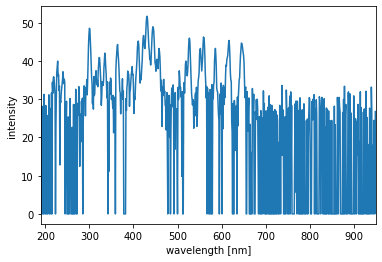

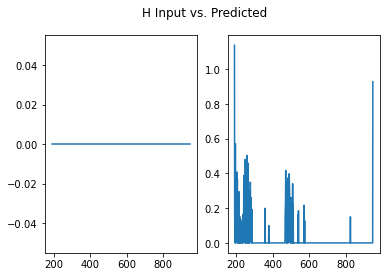

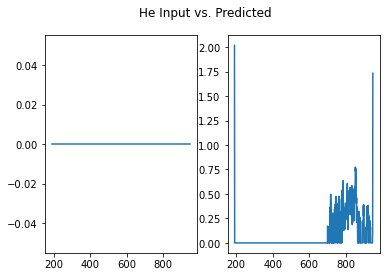

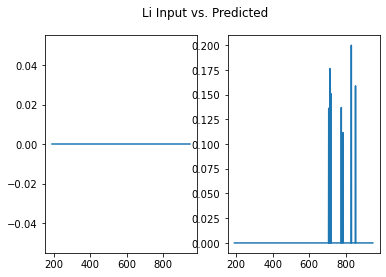

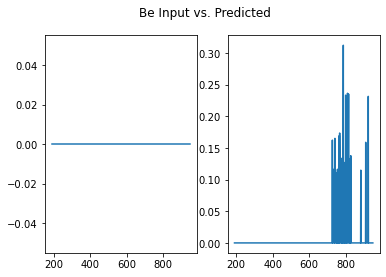

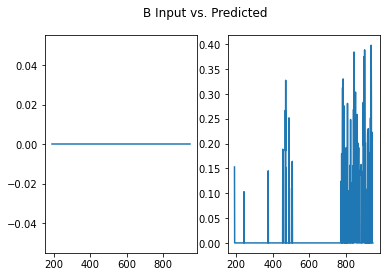

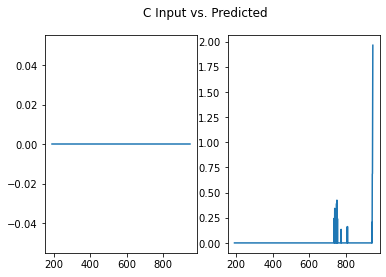

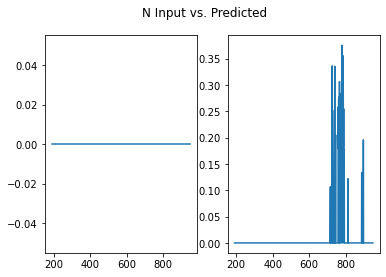

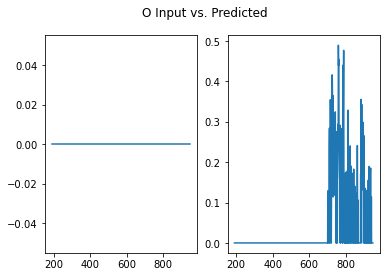

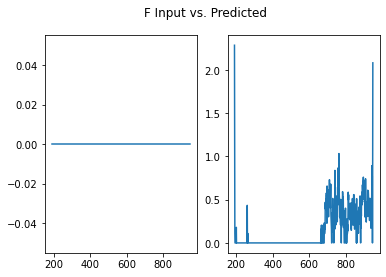

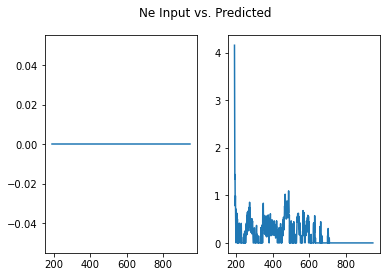

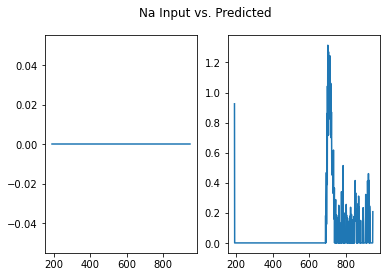

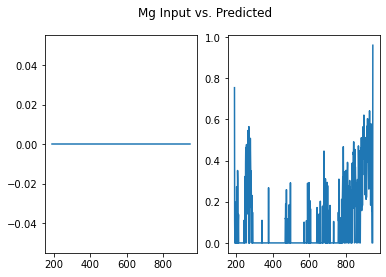

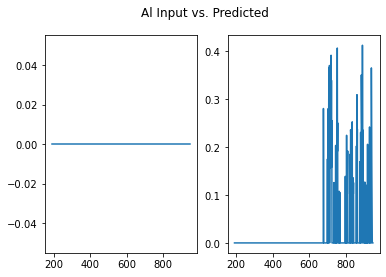

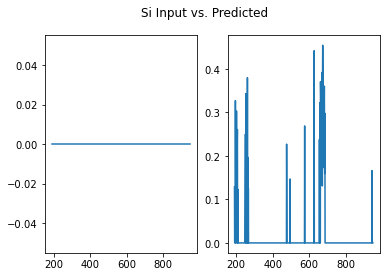

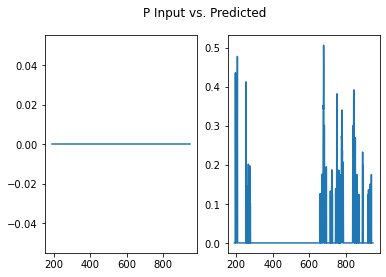

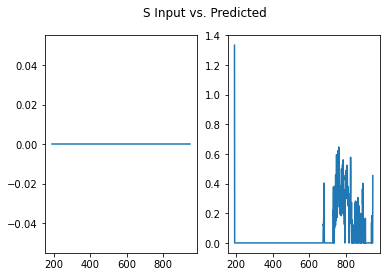

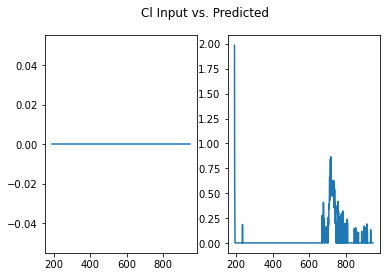

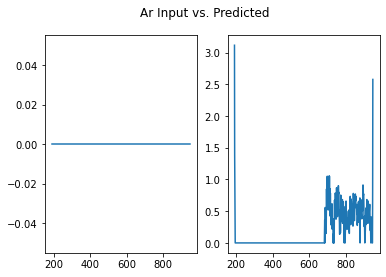

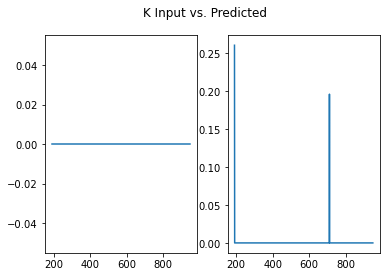

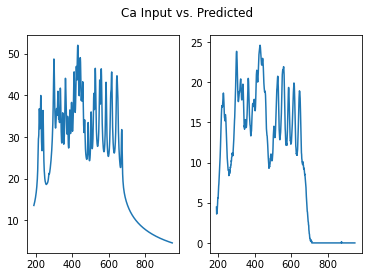

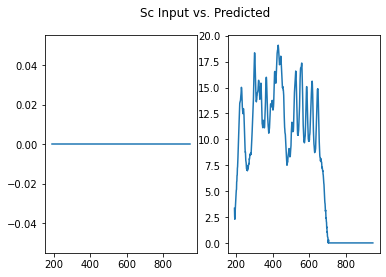

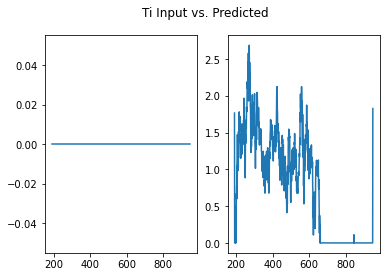

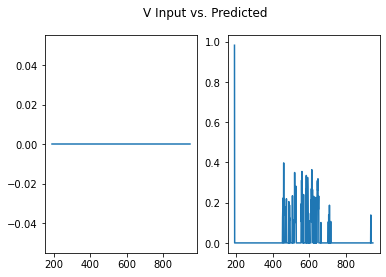

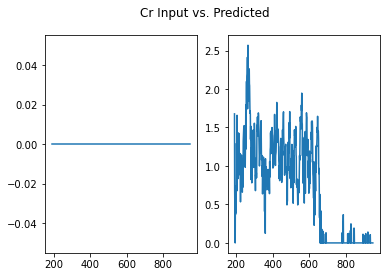

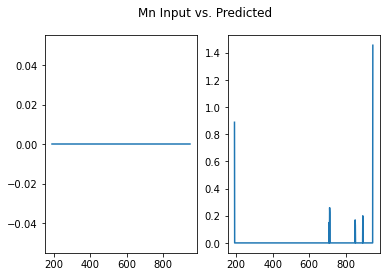

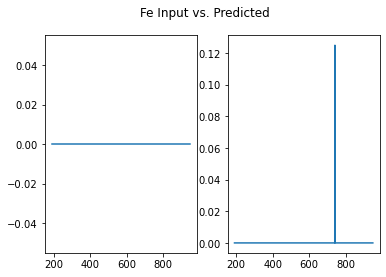

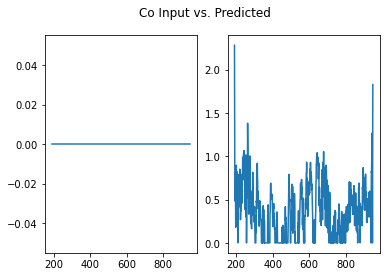

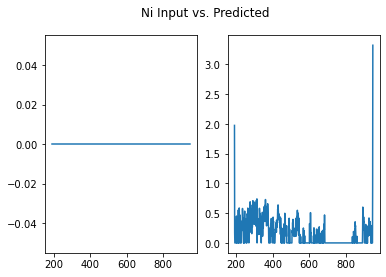

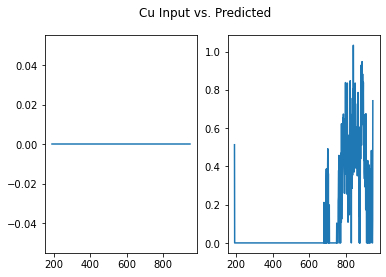

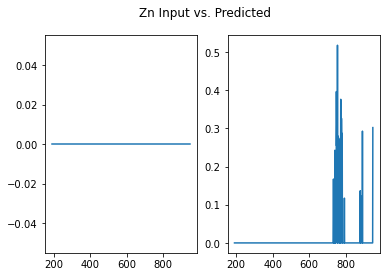

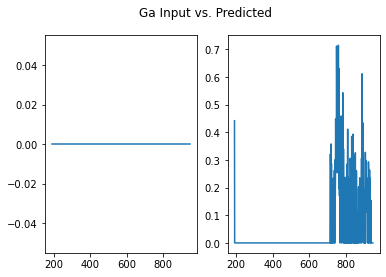

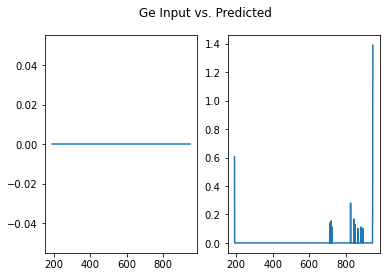

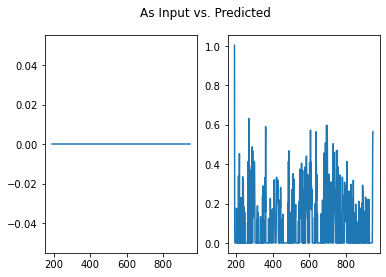

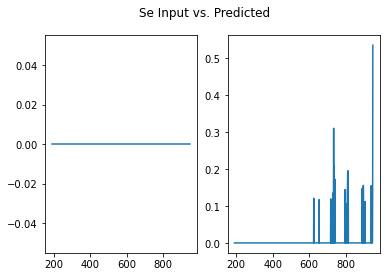

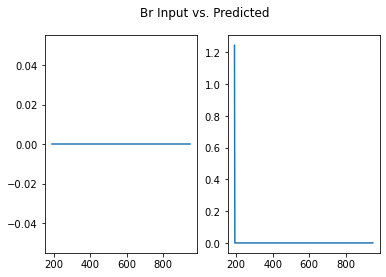

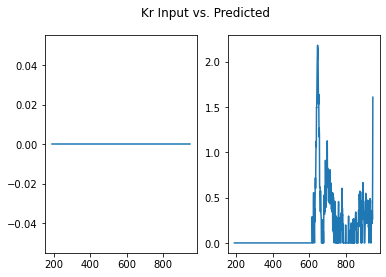

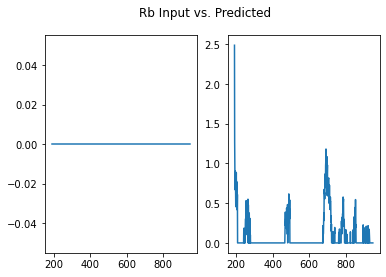

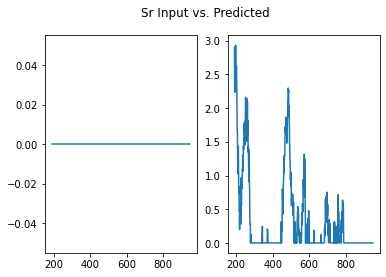

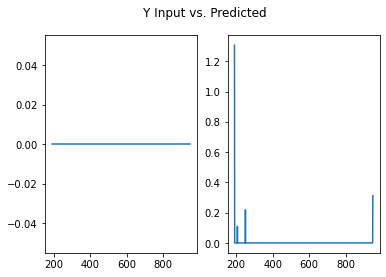

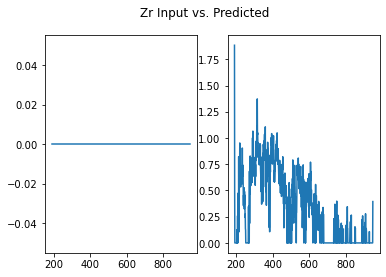

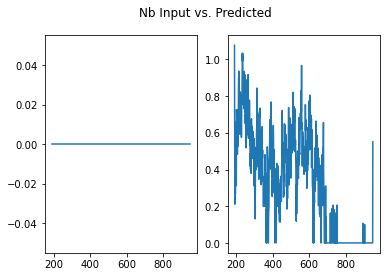

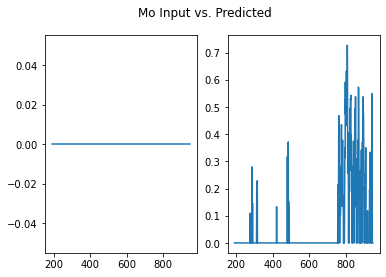

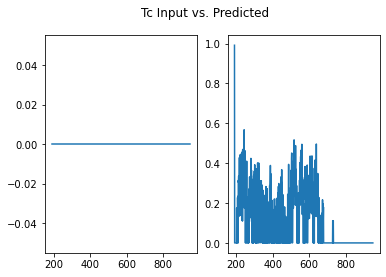

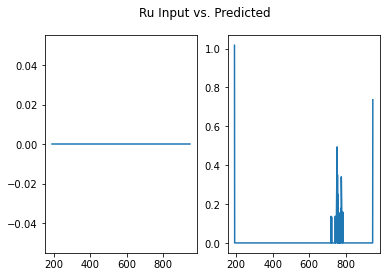

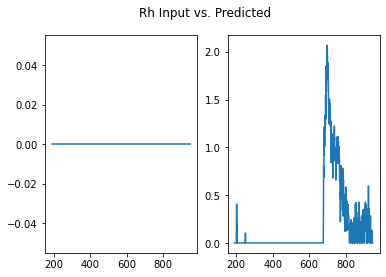

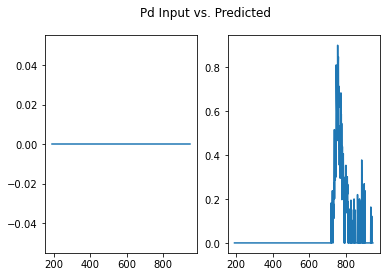

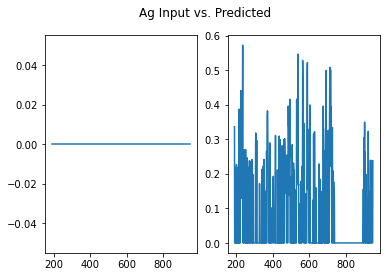

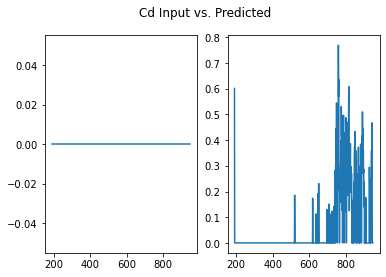

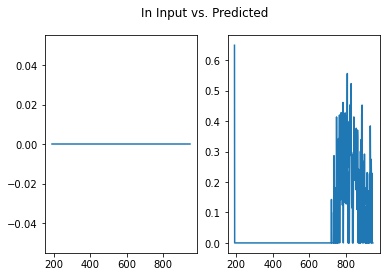

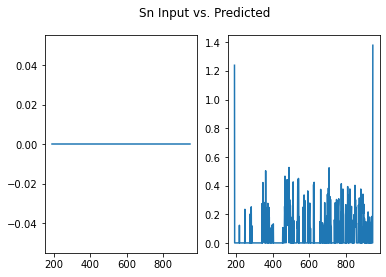

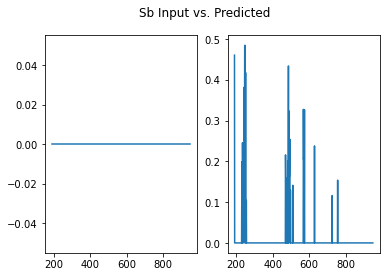

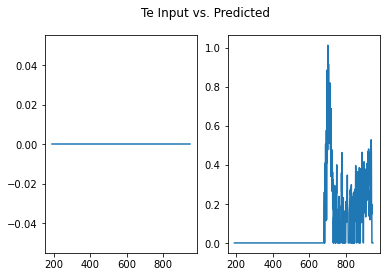

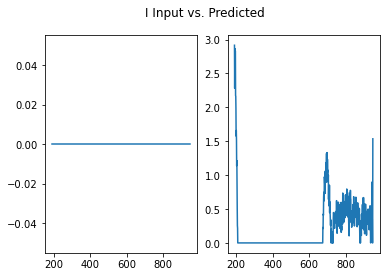

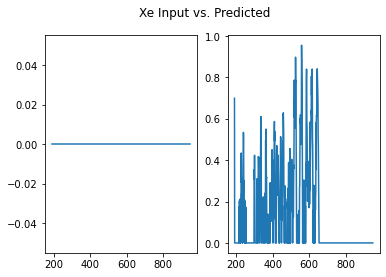

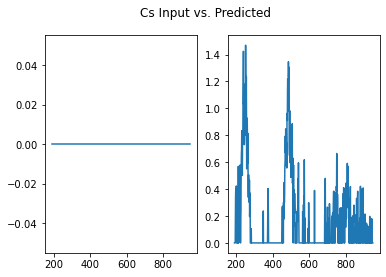

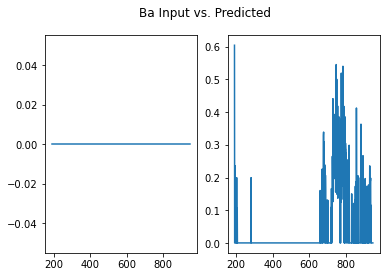

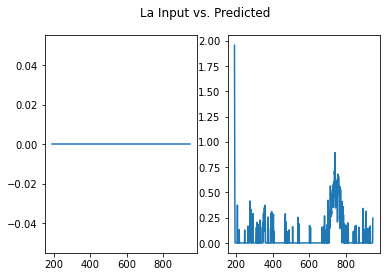

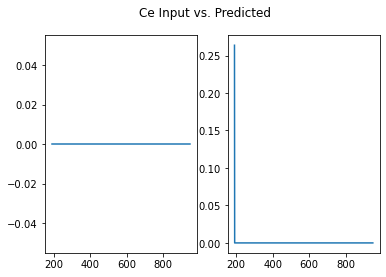

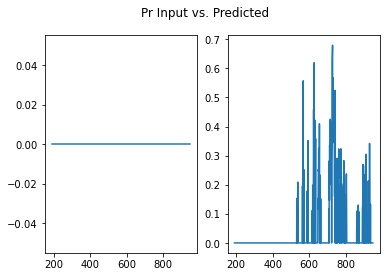

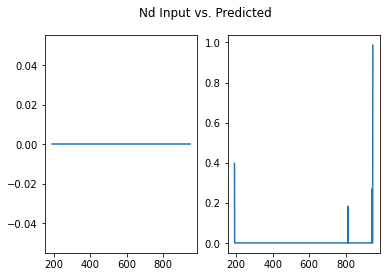

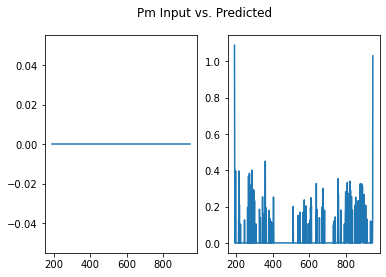

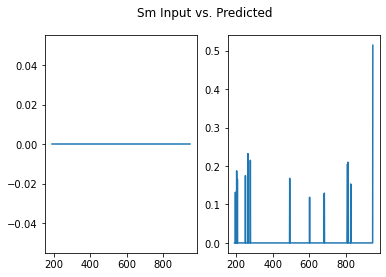

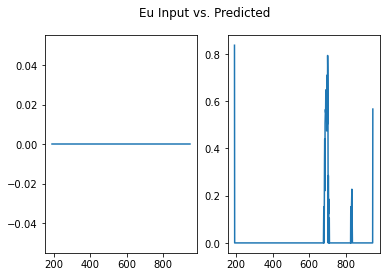

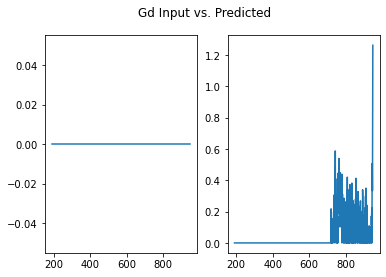

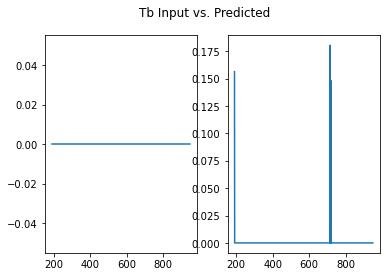

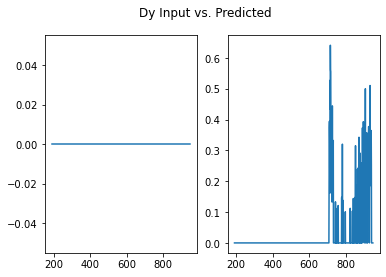

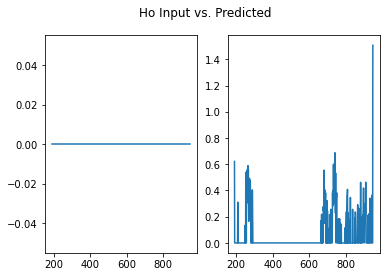

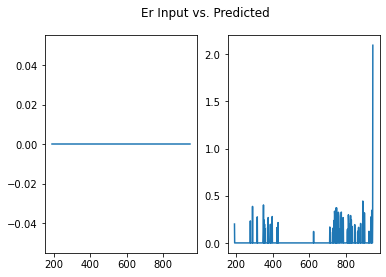

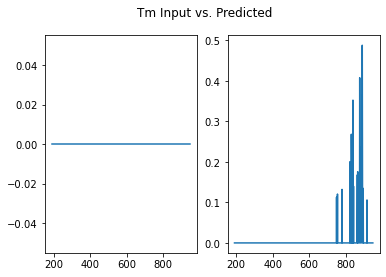

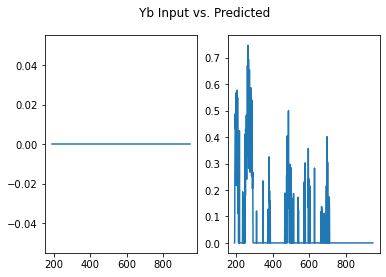

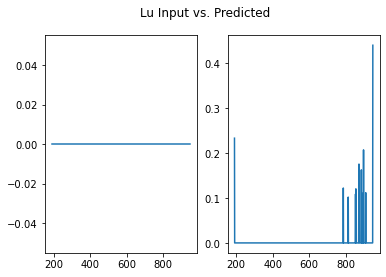

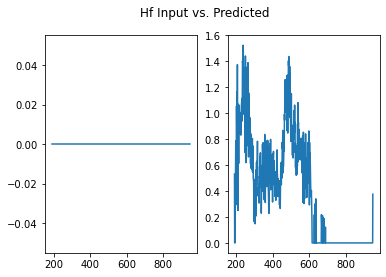

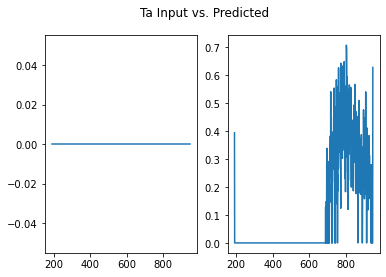

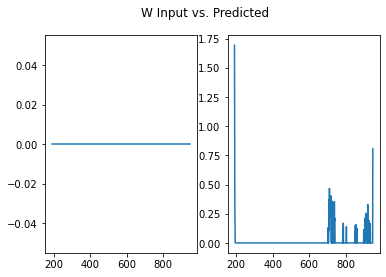

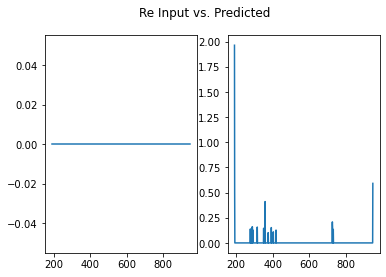

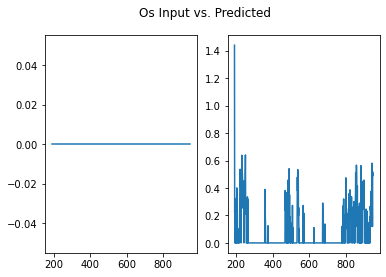

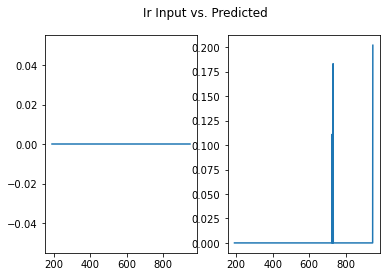

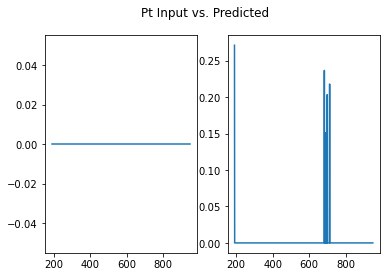

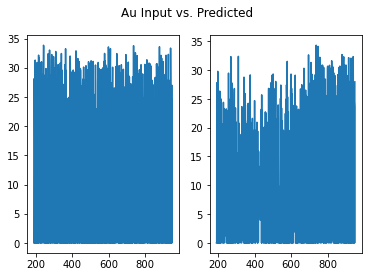

In [14]:
#look at the predicted vs. reference spectra
i_samp = 1 #vary up to 9999
x_sample = x_data[i_samp][None, :, :] #need correct dimensions with batch for prediction
y_sample = y_data[i_samp].detach().numpy() #[22][760] # 20+2 (el + art + noi) spectra

#composite spectra and components
#print(f"sum x: {torch.sum((torch.exp(x_sample[0][0])-1)/1000)}")
#show the element fractions
for i in range(el_count):
    frac = np.sum((np.exp(y_sample[i]) - 1)/1000)
    if frac > 0:
        print(f"{elem_symb[i]}: {frac:>4f}")
        
wave = np.arange(190,950)
#first plot the composite input spectrum we're trying to decompose
plt.plot(wave, x_sample[0][0])
plt.xlabel('wavelength [nm]')
plt.ylabel('intensity')
plt.xlim([190, 950])
plt.show

#prediction
plot_thresh = 0.1
model.eval()
with torch.no_grad():
    pred = model(x_sample)
    y_pred = pred[0].detach().numpy() #[22][760] corresponding predictions for y_sample
    y_pred[y_pred < plot_thresh] = 0

    #https://matplotlib.org/3.5.0/tutorials/introductory/usage.html#the-object-oriented-interface-and-the-pyplot-interface
    def pred_plot(ax, data1, data2, param_dict):
        out = ax.plot(data1, data2, **param_dict)
        return out
    for i in range(y_sample.shape[0]):
        fig, (ax1, ax2) = plt.subplots(1, 2)
        fig.suptitle(f'{elem_symb[i]} Input vs. Predicted ')
        pred_plot(ax1, wave, y_sample[i], {})
        pred_plot(ax2, wave, y_pred[i], {})